In [1]:
import numpy as np
import torch
from torch import nn

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import albumentations as A
import cv2
import PIL
from PIL import Image

from datasets import load_from_disk, Dataset, ClassLabel
from datasets import Image as ImageDS

from transformers import SegformerFeatureExtractor
from transformers import SegformerForSemanticSegmentation
from transformers import TrainingArguments
from transformers import logging
from transformers import Trainer

import evaluate

import multiprocessing
from multiprocessing import Pool
import shutil
import os

# avoid name clash
import copy as pcopy

from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.utils.io import capture_output

import optuna

# project library - datasets and dataloaders
from bus_data import *


In [2]:
code_path = os.getcwd()

train_dataset_path = "huggingface_bus_ds_four_combo_single_class"
video_dataset_path = "huggingface_bus_ds_video"

model_dir = "segformer_single_class_model"
output_dir = "segformer_single_class_outputs"
logging_dir = "segformer_single_class_logs"
trials_dir = "segformer_single_class_trials"

os.makedirs(model_dir, exist_ok=True)
# output_dir is recreated every trial
os.makedirs(logging_dir, exist_ok=True)
os.makedirs(trials_dir, exist_ok=True)

if os.uname()[1] == "media":
    # Florin's gaming PC
    data_volume = "/home/florin/data"
else:
    # Google Colab
    from google.colab import drive

    gdrive_path = "/content/gdrive"
    drive.mount(gdrive_path, force_remount=False)
    data_volume = gdrive_path + "/MyDrive"


# Create and/or load training dataset

In [3]:
train_df = pd.DataFrame(
    {
        "dataset": [],
        "image": [],
        "mask": [],
        "tumor": [],
    }
)

train_df = pd.concat([train_df, busis_dataset_make(data_volume)], ignore_index=True)
train_df = pd.concat([train_df, bus_dataset_b_make(data_volume)], ignore_index=True)
train_df = pd.concat(
    [train_df, dataset_busi_with_gt_make(data_volume)], ignore_index=True
)
train_df = pd.concat([train_df, mayo_dataset_make(data_volume)], ignore_index=True)

# convert Path to string, HuggingFace wants strings here
train_df["image"] = train_df["image"].apply(lambda x: str(x))
train_df["mask"] = train_df["mask"].apply(lambda x: [str(xi) for xi in x])
train_df["dataset_tumor"] = train_df["dataset"] + "_" + train_df["tumor"]
train_df


,dataset,image,mask,tumor,dataset_tumor
0,BUSIS,/home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case104.png,[/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case104_GT.bmp],benign,BUSIS_benign
1,BUSIS,/home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case325.png,[/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case325_GT.bmp],malignant,BUSIS_malignant
2,BUSIS,/home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case425.png,[/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case425_GT.bmp],malignant,BUSIS_malignant
3,BUSIS,/home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case339.png,[/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case339_GT.bmp],benign,BUSIS_benign
4,BUSIS,/home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case216.png,[/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case216_GT.bmp],malignant,BUSIS_malignant
...,...,...,...,...,...
1789,Mayo,/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/761858134_long.png,[/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/761858134_long_mask.png],benign,Mayo_benign
1790,Mayo,/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/679670173_long.png,[/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/679670173_long_mask.png],malignant,Mayo_malignant
1791,Mayo,/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/805361134_tran.png,[/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/805361134_tran_mask.png],benign,Mayo_benign
1792,Mayo,/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/451084310_dopp.png,[/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/451084310_dopp_mask.png],benign,Mayo_benign


In [4]:
# mapping classes to/from pixel values
id2label, label2id, num_labels = labels_ids_bus(multiclass=False)


In [5]:
def map_hf_train_ds(row):
    """
    input: a Pandas DF row with image and labels
    output: a dictionary with the image and the labels

    Convert mask pixel values as needed:
    - background = 0
    - lesion = 1
    """
    ret = {}

    ret["dataset"] = row["dataset"]
    ret["pixel_values"] = Image.open(row["pixel_values"]).convert("RGB")

    # merge all mask images into a single mask
    mask_list = [
        np.asarray(Image.open(x).convert("L"), dtype=np.uint8) for x in row["mask"]
    ]

    # set clip values based on mask existence
    if row["tumor"] == "benign" or row["tumor"] == "malignant":
        clip_val = label2id["lesion"]
    else:
        clip_val = label2id["unlabeled"]
    # build the actual mask image
    mask_frame = Image.fromarray(
        np.clip(np.amax(np.stack(mask_list), axis=0), a_min=0, a_max=clip_val)
    )
    ret["label"] = mask_frame

    ret["tumor"] = row["tumor"]
    ret["dataset_tumor"] = row["dataset_tumor"]
    return ret


def create_hf_train_dataset(df):
    """
    input: Pandas dataframe with the training dataset paths and labels
    output: HuggingFace dataset with training data
    """
    dataset = Dataset.from_dict(
        {
            "dataset": df["dataset"].to_list(),
            "pixel_values": df["image"].to_list(),
            "mask": df["mask"].to_list(),
            "tumor": df["tumor"].to_list(),
            "dataset_tumor": df["dataset_tumor"].to_list(),
        }
    )
    dataset = dataset.map(map_hf_train_ds, num_proc=multiprocessing.cpu_count())
    dataset = dataset.cast_column(
        "dataset_tumor", ClassLabel(names=df["dataset_tumor"].unique().tolist())
    )
    dataset = dataset.cast_column(
        "tumor", ClassLabel(names=df["tumor"].unique().tolist())
    )
    dataset = dataset.cast_column(
        "dataset", ClassLabel(names=df["dataset"].unique().tolist())
    )
    dataset = dataset.cast_column("pixel_values", ImageDS())
    return dataset.remove_columns("mask")


# If HuggingFace dataset exists, load it.
# Otherwise create and save it.
if os.path.isdir(train_dataset_path):
    ds_hf = load_from_disk(train_dataset_path)
else:
    ds_hf = create_hf_train_dataset(train_df)
    ds_hf.save_to_disk(train_dataset_path)


In [6]:
ds_hf = ds_hf.shuffle(seed=1).train_test_split(
    test_size=0.2, stratify_by_column="dataset_tumor", seed=20
)

train_ds = ds_hf["train"]
test_ds = ds_hf["test"]

# unprocessed images to visualize results at the end
# these don't have any augmentations or normalization
# TODO: eliminate the need for this DS
test_ds_orig = pcopy.deepcopy(test_ds)


Loading cached shuffled indices for dataset at huggingface_bus_ds_four_combo_single_class/cache-11f444989006ab82.arrow
Loading cached split indices for dataset at huggingface_bus_ds_four_combo_single_class/cache-a88d69231d67b2d8.arrow and huggingface_bus_ds_four_combo_single_class/cache-61fb3ecf6f4a89a4.arrow


In [7]:
train_ds.features


{'dataset': ClassLabel(names=['BUSIS', 'BUS_Dataset_B', 'Dataset_BUSI_with_GT', 'Mayo'], id=None),
 'pixel_values': Image(decode=True, id=None),
 'tumor': ClassLabel(names=['benign', 'malignant', 'normal'], id=None),
 'dataset_tumor': ClassLabel(names=['BUSIS_benign', 'BUSIS_malignant', 'BUS_Dataset_B_benign', 'BUS_Dataset_B_malignant', 'Dataset_BUSI_with_GT_benign', 'Dataset_BUSI_with_GT_malignant', 'Dataset_BUSI_with_GT_normal', 'Mayo_benign', 'Mayo_malignant'], id=None),
 'label': Image(decode=True, id=None)}

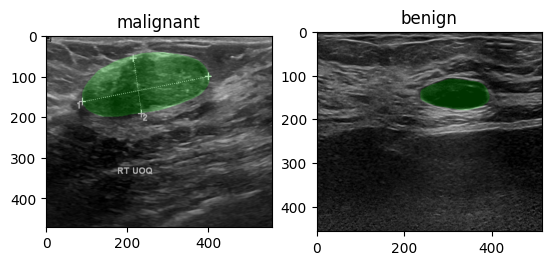

In [8]:
def color_palette(mpl_format=False):
    """
    output: pixel values for classes in predictions

    Contains values for the unlabeled background,
    and also for the labeled objects.
    """
    colors_list = [
        [0, 0, 0],
        [0, 255, 0],
        [255, 0, 0],
    ]
    if mpl_format:
        colors_list = [tuple([ch / 255.0 for ch in color]) for color in colors_list]
    return colors_list


def get_seg_overlay(image, seg):
    """
    input: an image and a mask
    output: the image and the mask combined, colorized by class
    """
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    palette = np.array(color_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.8 + color_seg * 0.2
    img = img.astype(np.uint8)

    return img


test_img_0 = get_seg_overlay(
    test_ds_orig[1]["pixel_values"], np.array(test_ds_orig[1]["label"])
)
test_img_2 = get_seg_overlay(
    test_ds_orig[2]["pixel_values"], np.array(test_ds_orig[2]["label"])
)

f, axs = plt.subplots(1, 2)

axs[0].set_title("malignant", {"fontsize": 12})
axs[0].imshow(test_img_0)
axs[1].set_title("benign", {"fontsize": 12})
axs[1].imshow(test_img_2)


# Augmentations and feature extraction (normalize, resize)

In [9]:
# normalize images for the transformer input
# make sure data formats are right
feature_extractor = SegformerFeatureExtractor(do_normalize=True)

rotate_limit = 20
shear_limit = 20

# modeled loosely after the default FastAI augments
training_augments = A.Compose(
    [
        A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.9),
        A.HorizontalFlip(p=0.5),
        A.Rotate(
            limit=(-rotate_limit, rotate_limit),
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_REFLECT_101,
            mask_value=0,
            p=0.9,
        ),
        A.Affine(
            scale=(0.833, 1.2),
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=None,
            shear={"x": (-shear_limit, shear_limit), "y": (-shear_limit, shear_limit)},
            interpolation=cv2.INTER_LINEAR,
            cval_mask=0,
            p=0.9,
        ),
    ]
)


def train_transforms(example_batch):
    """
    input: a batch of images and masks
    output: augmented and preprocessed images and masks

    This is for training.

    Images get all the augmentations, including pixel-value (brightness, contrast).
    Images also get feature-extracted (normalized).

    Masks only get the geometric transforms (rotation, etc).
    """
    batch_items = list(
        zip(
            [x for x in example_batch["pixel_values"]],
            [x for x in example_batch["label"]],
        )
    )
    batch_items_aug = [
        training_augments(
            image=np.array(x[0]),
            mask=np.array(x[1]),
        )
        for x in batch_items
    ]
    images = [i["image"] for i in batch_items_aug]
    labels = [i["mask"] for i in batch_items_aug]
    inputs = feature_extractor(images, labels)
    return inputs


def val_transforms(example_batch):
    """
    input: a batch of images and masks
    output: augmented and preprocessed images and masks

    This is for validation while training. No augmentations done here.

    Images get normalized.
    """
    images = [x for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = feature_extractor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)


# Show samples from the training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 512) (512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

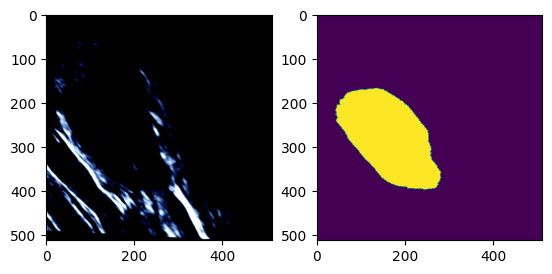

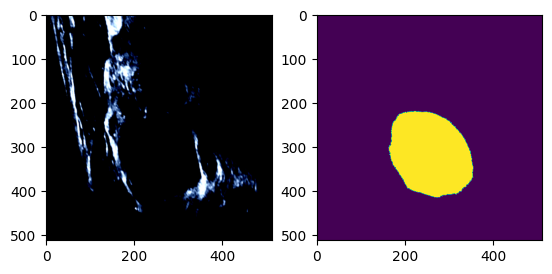

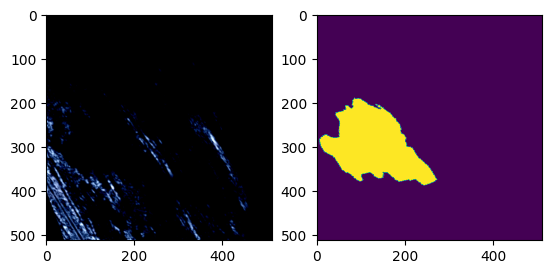

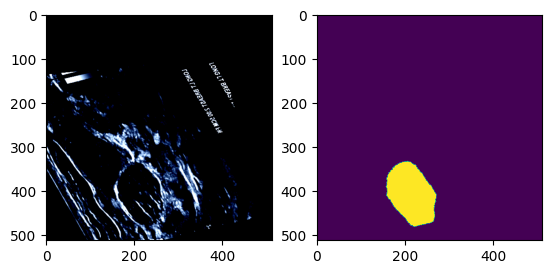

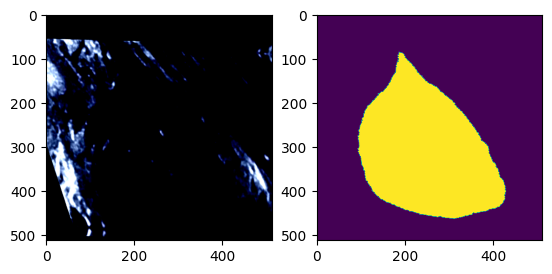

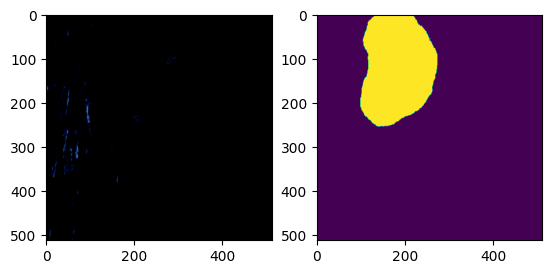

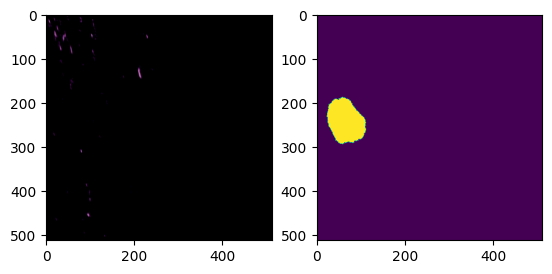

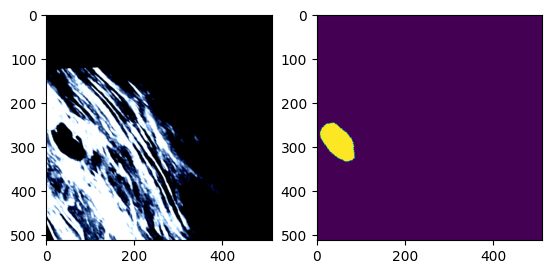

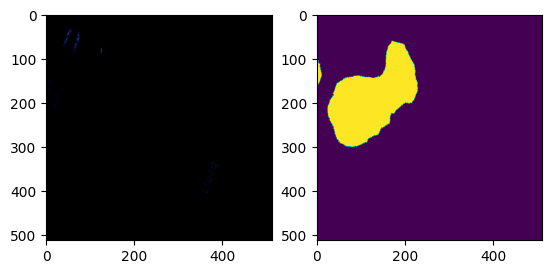

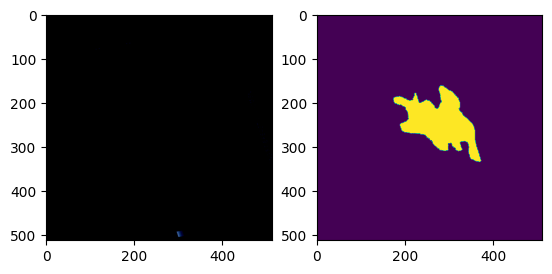

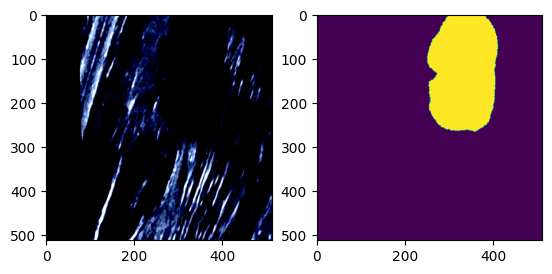

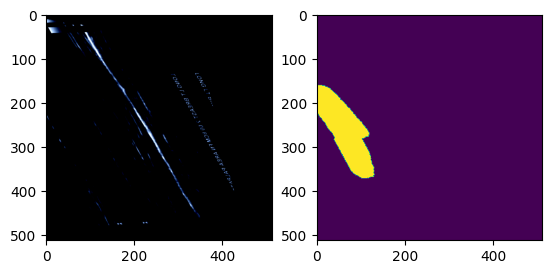

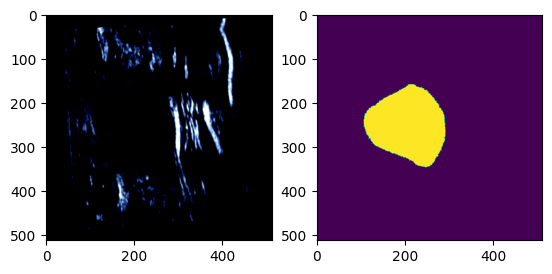

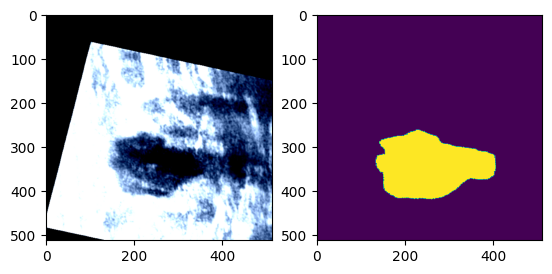

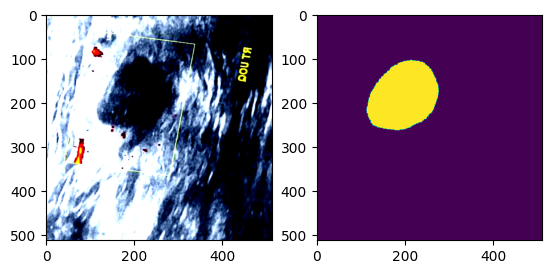

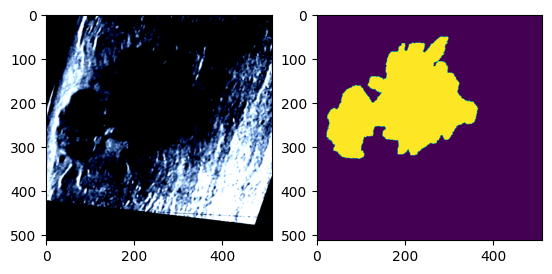

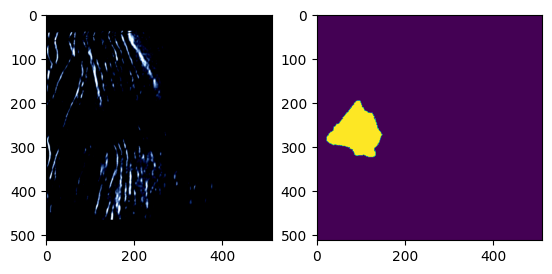

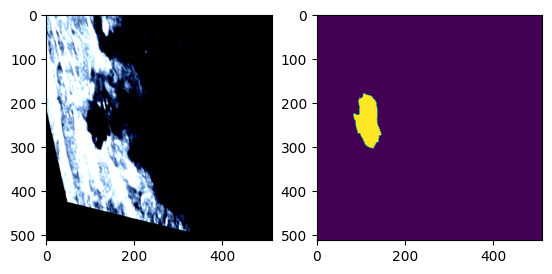

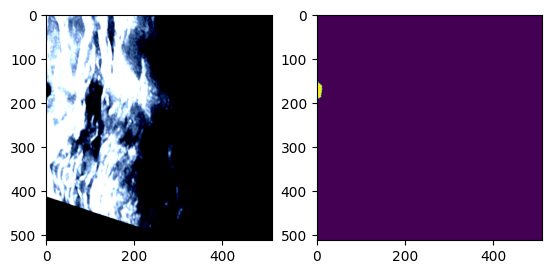

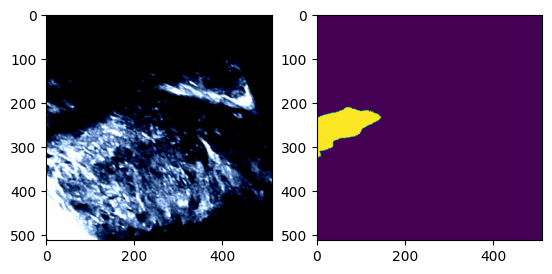

In [10]:
n_img = 20

for i in range(n_img):
    train_item = train_ds[i]
    if i == 0:
        print(train_item["pixel_values"].shape, train_item["labels"].shape)
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(train_item["pixel_values"].T)
    ax[1].imshow(train_item["labels"].T)
plt.show()


# Load pretrained model, fine tune it on labeled datasets

In [11]:
metric = evaluate.load(
    # "evaluate/metrics/mean_iou",
    "mean_iou",
    num_process=multiprocessing.cpu_count(),
)


def compute_metrics(eval_pred):
    """
    Compute training / validation metrics.
    This is called by the trainer.
    """
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)

        # scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=feature_extractor.reduce_labels,
        )

        # BUG: ignore_index=0 doesn't work properly
        # mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
        #
        # IoU for index=0 is always 0, but it's never ignored
        # multiplying by 2 to fix it (2 metrics in the average, but the 2nd is always 0)
        mean_iou = metrics["mean_iou"]
        metrics.update({"mean_iou": 2.0 * mean_iou})

        # add per category metrics as individual key-value pairs
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update(
            {f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)}
        )
        metrics.update(
            {f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)}
        )

        return metrics


In [12]:
def objective(trial):
    """
    input: Optuna trial
    output: best model performance metric

    The objective function for hyperparameter optimization.
    Used by study.optimize()
    Calls train_model() with the appropriate hyperparameter values.
    Captures and logs all output from train_model().
    """
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True)

    # define log file, log parameters
    trial_number_pad = str(trial.number).zfill(10)
    output_file_name = trials_dir + "/trial_" + trial_number_pad
    with open(output_file_name, "w") as cf:
        print(f"{trial.params}\n", file=cf)

    # main training step
    with capture_output(stdout=True, stderr=True, display=True) as captured:
        best_metric = train_model(
            learning_rate=learning_rate,
            trial_number=trial.number,
        )
    with open(output_file_name, "a") as cf:
        print(captured.stdout, file=cf)
        print(captured.stderr, file=cf)

    del captured
    return best_metric


def train_model(learning_rate, trial_number):
    """
    input: hyperparameter values and trial number
    output: best IoU from model validation

    Load a pretrained model.
    Train it using the indicated hyperparameters.
    Save the best model.
    Return the best model performance.
    """

    # delete/recreate folder with per-trial best and latest models
    shutil.rmtree(output_dir, ignore_errors=True)
    os.makedirs(output_dir, exist_ok=True)

    # fixed hyperparameters
    # the model was chosen based on size
    pretrained_model_name = "nvidia/mit-b3"
    epochs = 30
    batch_size = 8

    # avoid printing useless warnings
    logging.set_verbosity(50)
    # load pretrained transformer from public repos
    model = SegformerForSemanticSegmentation.from_pretrained(
        pretrained_model_name,
        id2label=id2label,
        label2id=label2id,
        num_labels=num_labels,
    )
    # restore normal verbosity
    logging.set_verbosity(40)

    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=epochs,
        lr_scheduler_type="linear",
        warmup_ratio=1e-2,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        auto_find_batch_size=False,
        evaluation_strategy="steps",
        save_strategy="steps",
        save_steps=20,
        eval_steps=20,
        logging_dir=logging_dir + "/trial-" + str(trial_number).zfill(10),
        logging_steps=1,
        log_level="error",
        eval_accumulation_steps=5,
        disable_tqdm=False,
        load_best_model_at_end=False,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        optim="adamw_hf",
        push_to_hub=False,
        dataloader_num_workers=multiprocessing.cpu_count(),
        seed=20,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # extract best step data from trainer history
    validation_history = []
    for e in trainer.state.log_history:
        if "eval_mean_iou" in e:
            validation_history.append(e)
    best_metric = 0
    best_step = 0
    best_loss = 1
    for e in validation_history:
        if e["eval_loss"] < best_loss:
            best_loss = e["eval_loss"]
            best_metric = e["eval_mean_iou"]
            best_step = e["step"]
    print("")
    print(f"best step / metric / loss: {best_step} / {best_metric} / {best_loss}")

    # move this trial's best model to model_dir
    shutil.move(
        output_dir + "/checkpoint-" + str(best_step),
        model_dir + "/trial-" + str(trial_number).zfill(10),
    )

    del model
    torch.cuda.empty_cache()
    return best_metric


# study definition
study = optuna.create_study(
    direction="maximize",
    study_name="train-all-semantic-mitb3-take2",
    storage="sqlite:///segformer_single_class_optuna.db",
    load_if_exists=True,
)


[I 2023-02-03 09:56:14,343] Using an existing study with name 'train-all-semantic-mitb3-take2' instead of creating a new one.


In [13]:
study.optimize(objective, timeout=7 * 3600, show_progress_bar=True, gc_after_trial=True)
# study.optimize(objective, n_trials=1, show_progress_bar=True, gc_after_trial=True)


/home/florin/.local/lib/python3.10/site-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 00:00/

[I 2023-02-03 11:39:10,541] Trial 7 finished with value: 0.7847774420317636 and parameters: {'learning_rate': 2.922433472734994e-06}. Best is trial 2 with value: 0.8469904545709079.
[I 2023-02-03 13:22:57,732] Trial 8 finished with value: 0.7373471105262478 and parameters: {'learning_rate': 1.716552077531071e-06}. Best is trial 2 with value: 0.8469904545709079.
[I 2023-02-03 15:06:43,274] Trial 9 finished with value: 0.833585771021697 and parameters: {'learning_rate': 1.8500292080932878e-05}. Best is trial 2 with value: 0.8469904545709079.
[I 2023-02-03 16:50:15,374] Trial 10 finished with value: 0.8387087394950744 and parameters: {'learning_rate': 3.684230513098093e-05}. Best is trial 2 with value: 0.8469904545709079.
[I 2023-02-03 18:34:27,478] Trial 11 finished with value: 0.833059986302137 and parameters: {'learning_rate': 0.0007659705226401928}. Best is trial 2 with value: 0.8469904545709079.


# Show fine tuning results

In [14]:
best_trial = study.best_trial
print(f"Best Trial: {best_trial.number}")
print(f"Best Score: {best_trial.value}")
print(f"Best Params:")
for k, v in best_trial.params.items():
    print(f"\t{k}: {v}")


Best Trial: 2
Best Score: 0.8469904545709079
Best Params:
	learning_rate: 0.00017793481147945767


In [19]:
for fig in [
    optuna.visualization.plot_optimization_history(study),
    optuna.visualization.plot_slice(study),
]:
    fig.update_layout(
        autosize=False,
        width=1000,
        height=360,
    )
    fig.show()


# Reload best trial model

In [17]:
best_model_dir = model_dir + "/trial-" + str(best_trial.number).zfill(10)
logging.set_verbosity(50)
model = SegformerForSemanticSegmentation.from_pretrained(
    best_model_dir, id2label=id2label, label2id=label2id, num_labels=num_labels
)
model.to("cuda:0")
logging.set_verbosity(40)


# Sample predictions on the validation dataset

  0%|          | 0/20 [00:00<?, ?it/s]

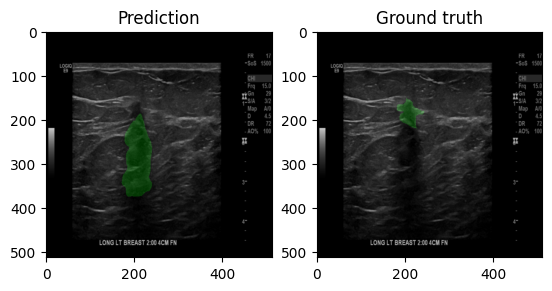

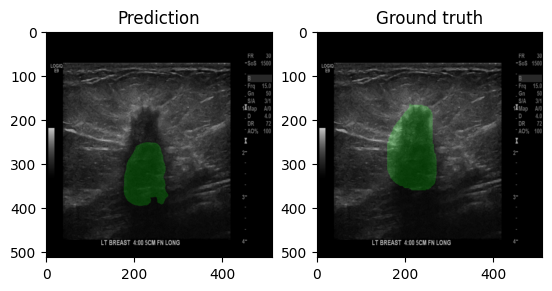

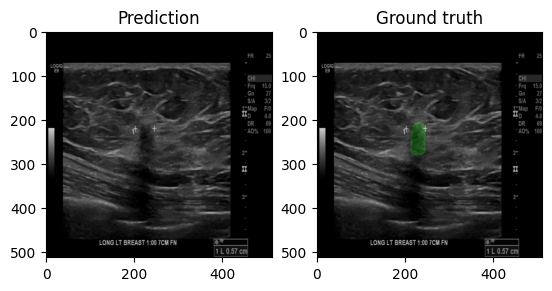

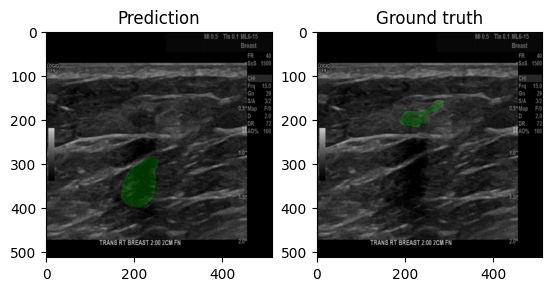

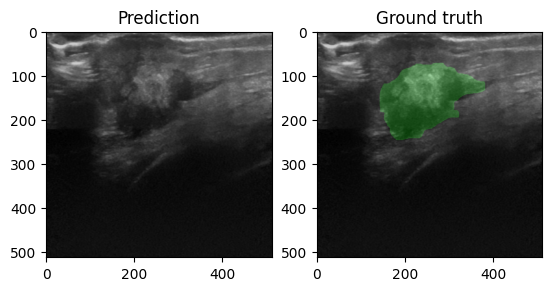

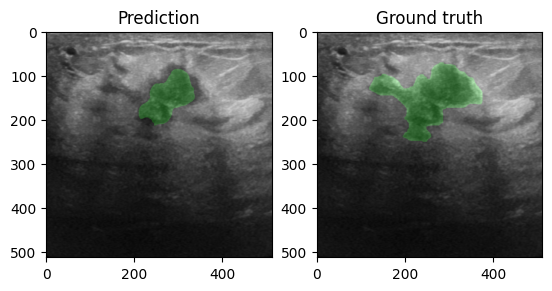

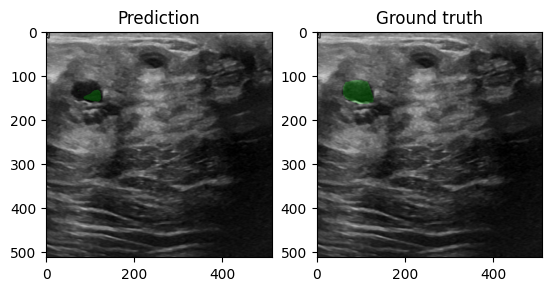

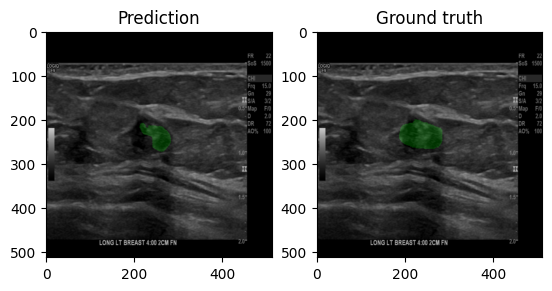

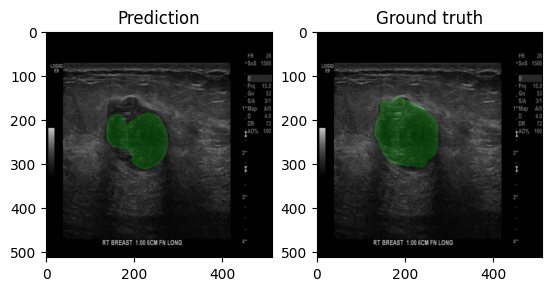

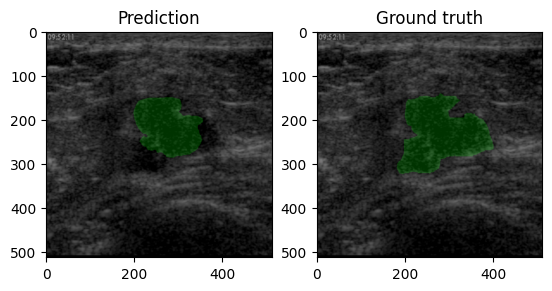

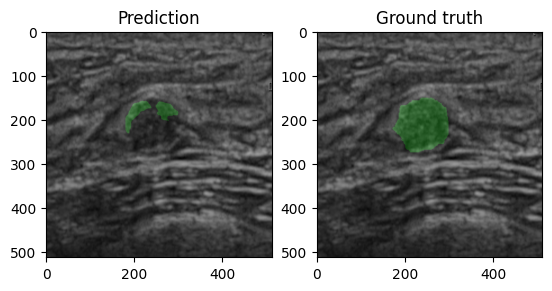

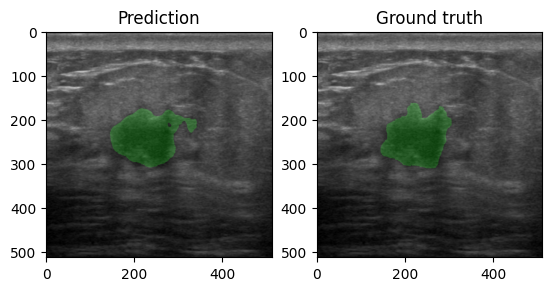

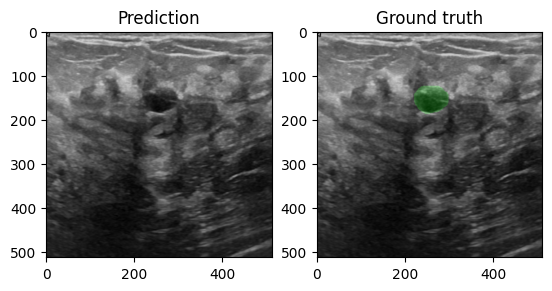

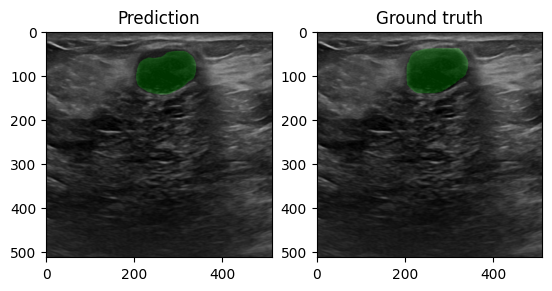

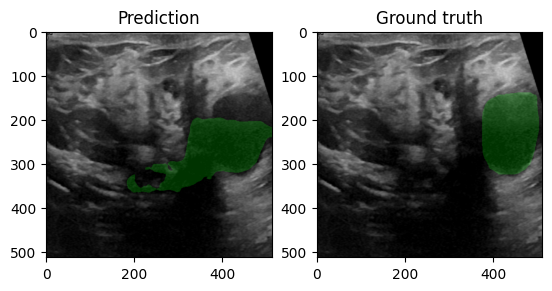

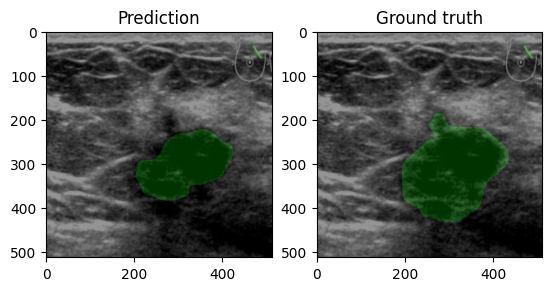

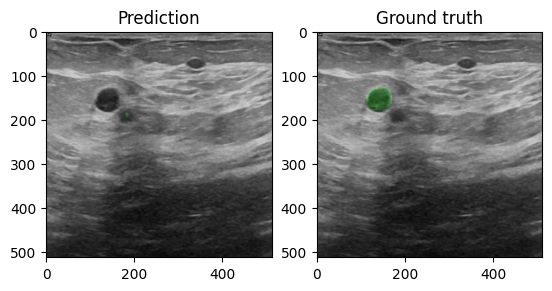

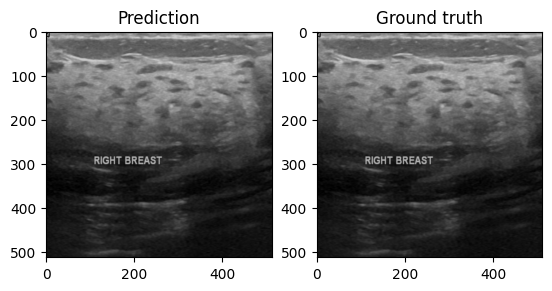

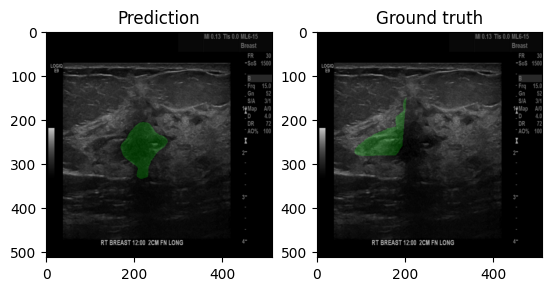

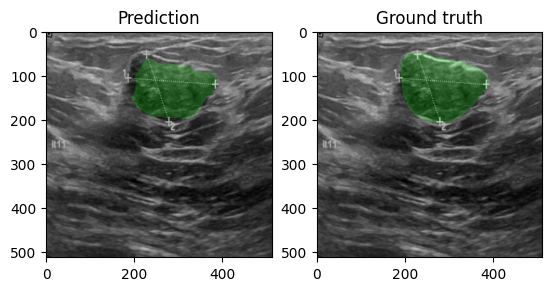

In [23]:
for i_ind in tqdm(range(80, 100)):
    image = test_ds[i_ind]["pixel_values"]
    gt_seg = test_ds[i_ind]["labels"]

    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs.to("cuda:0")
    outputs = model(**inputs)
    logits = outputs.logits

    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.shape[1:],  # (height, width)
        mode="bilinear",
        align_corners=False,
    )

    # Second, apply argmax on the class dimension
    pred_seg = upsampled_logits.argmax(dim=1)[0]

    image_orig = test_ds_orig[i_ind]["pixel_values"]
    image_orig = image_orig.resize((512, 512), resample=PIL.Image.Resampling.BILINEAR)

    pred_img = get_seg_overlay(image_orig, pred_seg.cpu())
    gt_img = get_seg_overlay(image_orig, np.array(gt_seg))
    f, axs = plt.subplots(1, 2)

    axs[0].set_title("Prediction", {"fontsize": 12})
    axs[0].imshow(pred_img)
    axs[1].set_title("Ground truth", {"fontsize": 12})
    axs[1].imshow(gt_img)


# Load video dataset

In [ ]:
buv_df = buv_dataset_make(data_volume)
# convert Path to string because HuggingFace needs the string type
buv_df["image"] = buv_df["image"].apply(lambda x: str(x))
buv_df


In [ ]:
def map_hf_video_ds(row):
    ret = {}
    ret["dataset"] = row["dataset"]
    ret["class"] = row["class"]
    ret["video"] = row["video"]
    ret["str_index"] = row["str_index"]
    # ret["pixel_values"] = [Image.open(pv).convert("RGB") for pv in row["pixel_values"]]
    ret["pixel_values"] = Image.open(row["pixel_values"]).convert("RGB")
    return ret


def create_hf_video_dataset(df):
    dataset = Dataset.from_dict(
        {
            "dataset": df["dataset"].to_list(),
            "class": df["class"].to_list(),
            "video": df["video"].to_list(),
            "pixel_values": df["image"].to_list(),
            "str_index": df["str_index"].to_list(),
        }
    )
    dataset = dataset.map(
        map_hf_video_ds,
        num_proc=multiprocessing.cpu_count(),
        writer_batch_size=multiprocessing.cpu_count() ** 2,
    )
    dataset = dataset.cast_column(
        "dataset", ClassLabel(names=df["dataset"].unique().tolist())
    )
    dataset = dataset.cast_column(
        "class", ClassLabel(names=df["class"].unique().tolist())
    )
    dataset = dataset.cast_column(
        "video", ClassLabel(names=df["video"].unique().tolist())
    )
    dataset = dataset.cast_column("pixel_values", ImageDS())
    return dataset


if os.path.isdir(video_dataset_path):
    ds_hf_video = load_from_disk(video_dataset_path)
else:
    ds_hf_video = create_hf_video_dataset(buv_df)
    ds_hf_video.save_to_disk(video_dataset_path)

feature_extractor = SegformerFeatureExtractor()


def video_transforms(example_batch):
    images = [x for x in example_batch["pixel_values"]]
    inputs = feature_extractor(images)
    return inputs


# Not needed, feature_extractor() is applied below in the loop.
# ds_hf_video.set_transform(video_transforms)


In [ ]:
ds_hf_video[0]


# Generate mask predictions for video

"""
video_dataloader = DataLoader(
    ds_hf_video,
    batch_size=multiprocessing.cpu_count(),
    num_workers=multiprocessing.cpu_count(),
)

from transformers import BatchFeature
"""

palette = np.array(color_palette())
index_len = len(str(len(ds_hf_video)))

outdir_base = "frames"
outdir = outdir_base + "/masks_segformer_single_class"
shutil.rmtree(outdir, ignore_errors=True)
os.makedirs(outdir, exist_ok=True)

for i, frame in tqdm(enumerate(ds_hf_video), total=len(ds_hf_video)):
    inputs = feature_extractor(images=frame["pixel_values"], return_tensors="pt").to(
        "cuda:0"
    )
    outputs = model(**inputs)
    logits = outputs.logits.cpu()
    ups_logits = nn.functional.interpolate(
        logits,
        size=(512, 512),
        mode="bilinear",
        align_corners=False,
    )
    predicted_segments = ups_logits.argmax(dim=1)[0]
    mask = Image.fromarray(predicted_segments.numpy().astype(np.uint8), mode="L")
    image_index_str = str(i).rjust(index_len, "0")
    mask.save(outdir + "/f" + image_index_str + ".png", format="png")

    # color_seg = np.zeros((predicted_segments.shape[0], predicted_segments.shape[1], 3), dtype=np.uint8)
    # for label, color in enumerate(palette):
    # color_seg[predicted_segments == label, :] = color


# Render a few samples from the video dataset

In [ ]:
feature_extractor = SegformerFeatureExtractor()

bdl = buv_df.shape[0]
# for i_ind in tqdm(range(buv_df.shape[0])):
for i_ind in tqdm(list(range(5)) + list(range(bdl - 5, bdl))):
    df_row = buv_df.loc[i_ind]
    image = Image.open(df_row["image"])
    image_resize = image.resize((128, 128), resample=PIL.Image.Resampling.BILINEAR)

    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs.to("cuda:0")
    outputs = model(**inputs)
    logits = outputs.logits

    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image_resize.shape,  # (height, width)
        mode="bilinear",
        align_corners=False,
    )

    # Second, apply argmax on the class dimension
    pred_seg = upsampled_logits.argmax(dim=1)[0]

    pred_img = get_seg_overlay(image_resize, pred_seg.cpu())

    f, axs = plt.subplots(1, 2)

    axs[0].set_title("Prediction", {"fontsize": 12})
    axs[0].imshow(pred_img)
    axs[1].set_title("Original Image", {"fontsize": 12})
    axs[1].imshow(image_resize)
